<h3>Prediction of game popularity using Machine Learning
(การทำนายความนิยมของเกมด้วย Machine Learning)</h3>

# Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install xgboost -U
!pip install catboost -U
!pip install optuna -U
!pip install lightgbm==v2.2.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 10.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.3/224.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.6 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 3.3.5
    Uninstalling lightgbm-3.3.5:
      Successfully uninstalled lightgbm-3.3.5


In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os
import pickle
import optuna
import itertools

from numpy import argmax
from keras.models import Sequential
from keras.layers import Dense, InputLayer 
from keras.layers import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split 

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score

from keras.utils import to_categorical
from catboost import Pool, metrics, cv

# Classification
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [ ]:
data = pd.read_pickle('/content/drive/MyDrive/CP499_INDIVIDUAL_COMPUTER_PROJECT_II/data/proprocess_pc_game_data.pkl')
data

,Achievements,Positive_ratings,Negative_ratings,Average_playtime,Median_playtime,Estimated_sales,Price,Month,Year,Genres_Action,...,Developer_rokapublish,Developer_roseVeRte,Developer_stariy8419,Developer_upjers,Developer_vadimalexepta,Developer_КиКо,Developer_凝冰剑斩,Developer_哈视奇科技,Developer_橘子班,Developer_橙光游戏
0,0,124534,3339,17612,317,9,7.19,11,2000,1,...,0,0,0,0,0,0,0,0,0,0
1,0,3318,633,277,62,8,3.99,4,1999,1,...,0,0,0,0,0,0,0,0,0,0
2,0,3416,398,187,34,8,3.99,5,2003,1,...,0,0,0,0,0,0,0,0,0,0
3,0,1273,267,258,184,8,3.99,6,2001,1,...,0,0,0,0,0,0,0,0,0,0
4,0,5250,288,624,415,8,3.99,11,1999,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27053,7,3,0,0,0,0,2.09,4,2019,0,...,0,0,0,0,0,0,0,0,0,0
27054,0,8,1,0,0,0,1.69,4,2019,1,...,0,0,0,0,0,0,0,0,0,0
27055,24,0,1,0,0,0,3.99,4,2019,1,...,0,0,0,0,0,0,0,0,0,0
27056,0,2,0,0,0,0,5.19,4,2019,0,...,0,0,0,0,0,0,0,0,0,0


# Train Models

**train/test split**

In [ ]:
X = data.drop(['Estimated_sales'], axis = 1)
y = data['Estimated_sales']

# แยก train_test_split ด้วยขนาด 80:20 และใช้ random_state ที่ 110
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.2 , random_state = 110)
sk_folds = StratifiedKFold(n_splits = 5, shuffle=True)

In [ ]:
cv_acc_score = []
cv_f1_score = []
cv_auc_score = []

# Function for Cross Validation
def cross_validation(model):
  scores = ["accuracy", "f1_weighted", "roc_auc_ovr_weighted"]
  for i in scores:
    score = cross_val_score(model, X_train, y_train, cv = sk_folds, scoring = i, n_jobs=-1)

    if i == "accuracy":
      cv_acc_score.append(score.mean())
      print("Cross Validation Accuracy Scores: ", score)
      print("Average CV Accuracy Score: ", score.mean(), "\n")
    elif i == "f1_weighted":
      cv_f1_score.append(score.mean())
      print("Cross Validation F1 Scores: ", score)
      print("Average CV F1 Score: ", score.mean(), "\n")
    else:
      cv_auc_score.append(score.mean())
      print("Cross Validation AUC Scores: ", score)
      print("Average CV AUC Score: ", score.mean(), "\n")

Find the best model from 12 models.

In [ ]:
# Logistic Regression
lr = LogisticRegression()
cross_validation(lr)

Cross Validation Accuracy Scores:  [0.7369515  0.73758374 0.73273273 0.73527374 0.74312774]
Average CV Accuracy Score:  0.7371338899745367 

Cross Validation F1 Scores:  [0.69626418 0.69834533 0.70330609 0.70138457 0.69957059]
Average CV F1 Score:  0.6997741506158784 

Cross Validation AUC Scores:  [0.9271417  0.92097016 0.92395103 0.92517149 0.92830638]
Average CV AUC Score:  0.9251081506512355 



In [ ]:
# Random Forest
rf = RandomForestClassifier()
cross_validation(rf)

Cross Validation Accuracy Scores:  [0.78591224 0.77823978 0.77154077 0.78239778 0.77823978]
Average CV Accuracy Score:  0.7792660701205736 

Cross Validation F1 Scores:  [0.75246994 0.76290684 0.75437734 0.76028999 0.74257606]
Average CV F1 Score:  0.7545240361652761 

Cross Validation AUC Scores:  [0.95966866 0.95678379 0.95986187 0.95778683 0.96052788]
Average CV AUC Score:  0.9589258072479957 



In [ ]:
# K-Nearest Neighbors (KNN)
knn = KNeighborsClassifier()
cross_validation(knn)

Cross Validation Accuracy Scores:  [0.74341801 0.74797875 0.74682375 0.74151074 0.73596674]
Average CV Accuracy Score:  0.743139597227357 

Cross Validation F1 Scores:  [0.72440353 0.72771247 0.72645217 0.7172998  0.71705651]
Average CV F1 Score:  0.7225848957289559 

Cross Validation AUC Scores:  [0.90136314 0.89476861 0.89516558 0.89241895 0.8933813 ]
Average CV AUC Score:  0.8954195167157616 



In [ ]:
# Support Vector Machines (SVM)
svm = SVC(probability = True)
cross_validation(svm)

Cross Validation Accuracy Scores:  [0.7221709  0.72534073 0.72487872 0.73157773 0.72510973]
Average CV Accuracy Score:  0.7258155615199495 

Cross Validation F1 Scores:  [0.66386457 0.65932283 0.6545136  0.66454819 0.66628664]
Average CV F1 Score:  0.6617071647386802 

Cross Validation AUC Scores:  [0.93010213 0.92947776 0.92977241 0.92766704 0.92786708]
Average CV AUC Score:  0.9289772836434416 



In [ ]:
# Decision Tree
dct = DecisionTreeClassifier()
cross_validation(dct)

Cross Validation Accuracy Scores:  [0.75889145 0.74936475 0.75005775 0.76253176 0.75721876]
Average CV Accuracy Score:  0.7556128948276755 

Cross Validation F1 Scores:  [0.75186153 0.75925409 0.76980323 0.75261235 0.75353365]
Average CV F1 Score:  0.757412971083245 

Cross Validation AUC Scores:  [0.81616523 0.81736529 0.81625268 0.81193153 0.82200265]
Average CV AUC Score:  0.8167434764820742 



In [ ]:
# Naive Bayes
nb = GaussianNB()
cross_validation(nb)

Cross Validation Accuracy Scores:  [0.72471132 0.73689074 0.73273273 0.73180873 0.73434973]
Average CV Accuracy Score:  0.7320986504358329 

Cross Validation F1 Scores:  [0.69788998 0.69418767 0.70477763 0.70209989 0.69391379]
Average CV F1 Score:  0.6985737924630009 

Cross Validation AUC Scores:  [0.91636011 0.91239203 0.91804247 0.92360707 0.91077171]
Average CV AUC Score:  0.9162346774125206 



In [ ]:
# LightGBM 
lgb = LGBMClassifier()
cross_validation(lgb)

Cross Validation Accuracy Scores:  [0.79145497 0.8004158  0.7951028  0.78794179 0.80642181]
Average CV Accuracy Score:  0.7962674310480315 

Cross Validation F1 Scores:  [0.78180216 0.80118298 0.80361557 0.79283368 0.79073773]
Average CV F1 Score:  0.7940344236018181 

Cross Validation AUC Scores:  [0.94133325 0.95360383 0.96579304 0.93489388 0.95543837]
Average CV AUC Score:  0.9502124726246347 



In [ ]:
# XGBoost
xgb = XGBClassifier() 
cross_validation(xgb)

Cross Validation Accuracy Scores:  [0.81316397 0.80503581 0.8031878  0.80572881 0.8034188 ]
Average CV Accuracy Score:  0.8061070379315183 

Cross Validation F1 Scores:  [0.80446371 0.80359123 0.80367099 0.79209957 0.79834083]
Average CV F1 Score:  0.8004332657992984 

Cross Validation AUC Scores:  [0.96583574 0.96669286 0.96612676 0.96507599 0.9659463 ]
Average CV AUC Score:  0.9659355286146705 



In [ ]:
# AdaBoost
ada = AdaBoostClassifier()
cross_validation(ada)

Cross Validation Accuracy Scores:  [0.70300231 0.7006237  0.69415569 0.6955417  0.70870871]
Average CV Accuracy Score:  0.7004064216997242 

Cross Validation F1 Scores:  [0.04193098 0.66665418 0.670698   0.04559022 0.65967704]
Average CV F1 Score:  0.41691008187047524 

Cross Validation AUC Scores:  [0.70263166 0.70119698 0.73689766 0.70772806 0.7132485 ]
Average CV AUC Score:  0.7123405715450573 



In [ ]:
# Gradient Boosting Machine
gbm = GradientBoostingClassifier()
cross_validation(gbm)

Cross Validation Accuracy Scores:  [0.80508083 0.7997228  0.78909679 0.7971818  0.79440979]
Average CV Accuracy Score:  0.7970984023639912 

Cross Validation F1 Scores:  [0.78520976 0.78875028 0.78670232 0.78218529 0.784844  ]
Average CV F1 Score:  0.7855383310375069 

Cross Validation AUC Scores:  [0.96351725 0.96085052 0.95999145 0.95625612 0.96219537]
Average CV AUC Score:  0.960562141118141 



In [ ]:
# CatBoost
cb = CatBoostClassifier(logging_level='Silent')
cross_validation(cb)

Cross Validation Accuracy Scores:  [0.81431871 0.81011781 0.80711481 0.80919381 0.81704782]
Average CV Accuracy Score:  0.8115585900343406 

Cross Validation F1 Scores:  [0.80808483 0.80372965 0.80463319 0.80089463 0.80072923]
Average CV F1 Score:  0.8036143072197234 

Cross Validation AUC Scores:  [0.96908666 0.96333515 0.9684754  0.96706402 0.96597131]
Average CV AUC Score:  0.9667865077635239 



In [ ]:
# Neural Network
nn = Sequential()
nn.add(Dense(50, input_shape=(X.shape[1],), activation='relu'))
nn.add(BatchNormalization())
nn.add(Dense(40, activation='relu'))
nn.add(BatchNormalization())
nn.add(Dense(10, activation='softmax'))

nn.compile(optimizer="adam", loss="SparseCategoricalCrossentropy", metrics=["accuracy"])
model = KerasClassifier(build_fn = lambda: nn, batch_size=100, verbose=0, epochs=100)
cross_validation(model)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...optimizer
......vars
.........0
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-05-06 14:18:33         2957
metadata.json                                  2023-05-06 14:18:33           64
variables.h5                                   2023-05-06 14:18:33       300688
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_1
......vars
.........0
.........1
....

File Name                                             Modified             Size
config.json                                    2023-05-06 14:20:39         2957
metadata.json                                  2023-05-06 14:20:39           64
variables.h5                                   2023-05-06 14:20:39       300688
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...optimizer
......vars
.........0
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-05-06 14:20:39         2957
metadata.json                                  2023-05-06 14

# Compare Models

In [ ]:
ml_var = [lr, rf, knn, svm, dct, nb, lgb, xgb, ada, gbm, cb, nn]
ml_name = ['Logistic Regression', 'Random Forest', 'K-Nearest Neighbors (KNN)', 'Support Vector Machines (SVM)', 'Decision Tree', 'Naive Bayes', 'LightGBM', 'XGBoost', 'AdaBoost', 'Gradient Boosting Machine', 'CatBoost', 'Neural Network']

**Cross Validation Score**

In [ ]:
# ทำการตรวจสอบความแม่นยำโดยใช้ Accuracy Score / F1 Score / AUC Score (Area Under <ROC> Curve)

cv_score_df = pd.DataFrame(list(zip(ml_name, cv_acc_score, cv_f1_score, cv_auc_score)), columns=['Model', 'Accuracy CV Score', 'F1 CV Score', 'AUC CV Score'])
cv_score_df[cv_score_df.select_dtypes(include=['float64']).columns] *= 100
cv_score_df

,Model,Accuracy CV Score,F1 CV Score,AUC CV Score
0,Logistic Regression,73.713389,69.977415,92.510815
1,Random Forest,77.926607,75.452404,95.892581
2,K-Nearest Neighbors (KNN),74.313960,72.258490,89.541952
3,Support Vector Machines (SVM),72.581556,66.170716,92.897728
4,Decision Tree,75.561289,75.741297,81.674348
5,Naive Bayes,73.209865,69.857379,91.623468
6,LightGBM,79.626743,79.403442,95.021247
7,XGBoost,80.610704,80.043327,96.593553
8,AdaBoost,70.040642,41.691008,71.234057
9,Gradient Boosting Machine,79.709840,78.553833,96.056214


In [ ]:
best_cv_acc_score = max(cv_acc_score)
best_cv_f1_score = max(cv_f1_score)
best_cv_auc_score = max(cv_auc_score)
best_cv_acc_ML = ml_name[cv_acc_score.index(best_cv_acc_score)]
best_cv_f1_ML = ml_name[cv_f1_score.index(best_cv_f1_score)]
best_cv_acc_ML = ml_name[cv_auc_score.index(best_cv_auc_score)]

top_4_cv_model = cv_score_df.sort_values('Accuracy CV Score', ascending=False)['Model'].head(3)
print("Top 4 CV Model:", (top_4_cv_model.to_numpy()), "\n")

best_cv_ml = pd.DataFrame({'Model': [best_cv_acc_ML, best_cv_f1_ML, best_cv_acc_ML], 
                           'Score': [best_cv_acc_score, best_cv_f1_score, best_cv_auc_score]},
                            index=['Best Accuracy', 'Best F1', 'Best AUC'])

best_cv_ml[best_cv_ml.select_dtypes(include=['float64']).columns] *= 100
best_cv_ml

Top 4 CV Model: ['CatBoost' 'XGBoost' 'Gradient Boosting Machine'] 



,Model,Score
Best Accuracy,CatBoost,81.155859
Best F1,CatBoost,80.361431
Best AUC,CatBoost,96.678651


**Train Score**

In [ ]:
# ทำการตรวจสอบความแม่นยำโดยใช้ Accuracy Score / F1 Score / AUC Score (Area Under <ROC> Curve)

auc_train_score = []
acc_train_score = []
F1_train_score = []

best_acc_train_score, best_f1_train_score, best_auc_train_score,= 0, 0, 0
best_acc_train_ML, best_f1_train_ML, best_auc_train_ML = '', '', ''

for x in ml_var:

  if x == nn:
    x.fit(X_train, y_train, batch_size=100, verbose=0, epochs=100)
    nn_pred = x.predict(X_train)
    y_pred = nn_pred.argmax(1) 
    pred_prob = x.predict(X_train)
  else:
    x.fit(X_train, y_train)
    y_pred = x.predict(X_train) 
    pred_prob = x.predict_proba(X_train)  

  # Accuracy Score 
  acc_train_score.append(accuracy_score(y_train, y_pred))
  if accuracy_score(y_train, y_pred) > best_acc_train_score:
    best_acc_train_score = accuracy_score(y_train, y_pred)
    best_acc_train_ML = ml_name[ml_var.index(x)]

  # F1 Score
  F1_train_score.append(f1_score(y_train, y_pred, average='weighted'))
  if f1_score(y_train, y_pred, average='weighted') > best_f1_train_score:
    best_f1_train_score = f1_score(y_train, y_pred, average='weighted')
    best_f1_train_ML = ml_name[ml_var.index(x)]

  # AUC Score
  auc_train_score_cal = roc_auc_score(y_train, pred_prob, multi_class='ovr', average='weighted')
  auc_train_score.append(auc_train_score_cal)
  if auc_train_score_cal > best_auc_train_score:
    best_auc_train_score = auc_train_score_cal
    best_auc_train_ML = ml_name[ml_var.index(x)]

train_score_df = pd.DataFrame(list(zip(ml_name, acc_train_score, F1_train_score, auc_train_score)), columns=['Model', 'Accuracy Train Score', 'F1 Train Score', 'AUC Train Score'])
train_score_df

677/677 [==============================] - 1s 925us/step


,Model,Accuracy Train Score,F1 Train Score,AUC Train Score
0,Logistic Regression,0.737965,0.700197,0.926088
1,Random Forest,1.000000,1.000000,1.000000
2,K-Nearest Neighbors (KNN),0.816456,0.805963,0.972703
3,Support Vector Machines (SVM),0.730805,0.670850,0.929832
4,Decision Tree,1.000000,1.000000,1.000000
5,Naive Bayes,0.739998,0.708189,0.920883
6,LightGBM,0.915319,0.912827,0.987051
7,XGBoost,0.932505,0.930460,0.990119
8,AdaBoost,0.702485,0.673314,0.712104
9,Gradient Boosting Machine,0.843250,0.836566,0.970737


In [ ]:
top_4_train_model = train_score_df .sort_values('Accuracy Train Score', ascending=False)['Model'].head(3)
print("Top 4 Train Model:", (top_4_train_model.to_numpy()), "\n")

best_train_ml = pd.DataFrame({'Model': [best_acc_train_ML, best_f1_train_ML, best_acc_train_ML], 
                        'Score': [best_acc_train_score, best_f1_train_score, best_auc_train_score]},
                        index=['Best Accuracy', 'Best F1', 'Best AUC'])
best_train_ml

Top 4 Train Model: ['Random Forest' 'Decision Tree' 'XGBoost'] 



,Model,Score
Best Accuracy,Random Forest,1.0
Best F1,Random Forest,1.0
Best AUC,Random Forest,1.0


**Test Score**

In [ ]:
# ทำการตรวจสอบความแม่นยำโดยใช้ Accuracy Score / F1 Score / AUC Score (Area Under <ROC> Curve)

auc_test_score = []
acc_test_score = []
F1_test_score = []

best_acc_test_score, best_f1_test_score, best_auc_test_score,= 0, 0, 0
best_acc_test_ML, best_f1_test_ML, best_auc_test_ML = '', '', ''

for x in ml_var:

  if x == nn:
    nn_pred = x.predict(X_test)
    y_pred = nn_pred.argmax(1) 
    pred_prob = x.predict(X_test)
  else:
    y_pred = x.predict(X_test) 
    pred_prob = x.predict_proba(X_test)  

  # Accuracy Score 
  acc_test_score.append(accuracy_score(y_test, y_pred))
  if accuracy_score(y_test, y_pred) > best_acc_test_score:
    best_acc_test_score = accuracy_score(y_test, y_pred)
    best_acc_test_ML = ml_name[ml_var.index(x)]

  # F1 Score
  F1_test_score.append(f1_score(y_test, y_pred, average='weighted'))
  if f1_score(y_test, y_pred, average='weighted') > best_f1_test_score:
    best_f1_test_score = f1_score(y_test, y_pred, average='weighted')
    best_f1_test_ML = ml_name[ml_var.index(x)]

  # AUC Score
  auc_test_score_cal = roc_auc_score(y_test, pred_prob, multi_class='ovr', average='weighted')
  auc_test_score.append(auc_test_score_cal)
  if auc_test_score_cal > best_auc_test_score:
    best_auc_test_score = auc_test_score_cal
    best_auc_test_ML = ml_name[ml_var.index(x)]

test_score_df = pd.DataFrame(list(zip(ml_name, acc_test_score, F1_test_score, auc_test_score)), columns=['Model', 'Accuracy Test Score', 'F1 Test Score', 'AUC Test Score'])
test_score_df

170/170 [==============================] - 0s 998us/step


,Model,Accuracy Test Score,F1 Test Score,AUC Test Score
0,Logistic Regression,0.742794,0.705817,0.930453
1,Random Forest,0.798041,0.778379,0.960793
2,K-Nearest Neighbors (KNN),0.757391,0.742298,0.899723
3,Support Vector Machines (SVM),0.738729,0.680140,0.934669
4,Decision Tree,0.762380,0.763005,0.817932
5,Naive Bayes,0.743533,0.713470,0.920768
6,LightGBM,0.819660,0.814500,0.968823
7,XGBoost,0.819660,0.815042,0.968897
8,AdaBoost,0.706208,0.679626,0.713424
9,Gradient Boosting Machine,0.805248,0.797046,0.962140


In [ ]:
top_4_test_model = test_score_df .sort_values('Accuracy Test Score', ascending=False)['Model'].head(3)
print("Top 4 Test Model:", (top_4_test_model.to_numpy()), "\n")

best_test_ml = pd.DataFrame({'Model': [best_acc_test_ML, best_f1_test_ML, best_acc_test_ML], 
                        'Score': [best_acc_test_score, best_f1_test_score, best_auc_test_score]},
                        index=['Best Accuracy', 'Best F1', 'Best AUC'])
best_test_ml

Top 4 Test Model: ['LightGBM' 'XGBoost' 'CatBoost'] 



,Model,Score
Best Accuracy,LightGBM,0.819660
Best F1,XGBoost,0.815042
Best AUC,LightGBM,0.970009


# Hyperparameter Tuning / Optimize Model Performance

**Set parameter & score for tuning**

In [ ]:
def cb_objective(trial):

    param = {
        "iterations": trial.suggest_int("iterations", 1000, 1500),
        "depth": trial.suggest_int("depth", 1, 10),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 10),
        "border_count": trial.suggest_int("border_count", 128, 254),
        "random_strength": trial.suggest_int("random_strength", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 1),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 1),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cb_tuning = CatBoostClassifier(**param, verbose=False)
    rmse = cross_val_score(cb_tuning, X_train, y_train, cv = sk_folds, scoring = "neg_mean_squared_error", n_jobs=-1)
  
    return rmse.mean()

In [ ]:
def xgb_objective(trial):

    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "min_child_weight" : trial.suggest_int("min_child_weight", 1, 10),
        "subsample" : trial.suggest_float("subsample", 0.1, 1),
        "eta" : trial.suggest_float("eta", 0.001, 1),
        "gamma": trial.suggest_float("gamma", 0.001, 1),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 1),
        "colsample_bytree" : trial.suggest_float("colsample_bylevel", 0.01, 1),
    }

    xgb_tuning = XGBClassifier(**param) 
    rmse = cross_val_score(xgb_tuning, X_train, y_train, cv = sk_folds, scoring = "neg_mean_squared_error", n_jobs=-1)
  
    return rmse.mean()

In [ ]:
def lgb_objective(trial):

    param = {
        "objective": "multiclass",
        "boosting_type": "gbdt",
        "num_class": 10,
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_bin": trial.suggest_int("max_bin", 2, 100),
        "max_depth": trial.suggest_int("max_depth", -5, 25),
        "num_leaves" : trial.suggest_int("num_leaves", 10, 100),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 1),
    }

    lgb_tuning = LGBMClassifier(**param)
    rmse = cross_val_score(lgb_tuning, X_train, y_train, cv = sk_folds, scoring = "neg_mean_squared_error", n_jobs=-1)
  
    return rmse.mean()

In [ ]:
def optuna_tuning(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=30, n_jobs=-1, timeout=40000)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    
    return trial.params

**CatBoost**

In [ ]:
cb_best_param = optuna_tuning(cb_objective)

[I 2023-05-07 12:39:11,524] A new study created in memory with name: no-name-e69f22d3-870d-4707-a8cf-236235205ed2
[I 2023-05-07 13:08:01,398] Trial 0 finished with value: -0.34135605137914615 and parameters: {'iterations': 1372, 'depth': 2, 'l2_leaf_reg': 9, 'border_count': 229, 'random_strength': 3, 'learning_rate': 0.6820871641979749, 'colsample_bylevel': 0.9049946717916002, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.532159269431814}. Best is trial 0 with value: -0.34135605137914615.
[I 2023-05-07 13:13:19,951] Trial 6 finished with value: -0.3284210414002562 and parameters: {'iterations': 1172, 'depth': 3, 'l2_leaf_reg': 4, 'border_count': 167, 'random_strength': 1, 'learning_rate': 0.8075484196155945, 'colsample_bylevel': 0.8780805403608586, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.682692887822256}. Best is trial 6 with value: -0.3284210414002562.
[I 2023-05-07 13:15:50,465] Trial 10 finished with value: -0.3230623268498557 and parameters: {'iterations': 1

[I 2023-05-07 13:40:00,294] Trial 15 finished with value: -0.3195507392274136 and parameters: {'iterations': 1072, 'depth': 8, 'l2_leaf_reg': 5, 'border_count': 155, 'random_strength': 7, 'learning_rate': 0.556014359807582, 'colsample_bylevel': 0.7430704140623667, 'bootstrap_type': 'Bernoulli', 'subsample': 0.8640544843351202}. Best is trial 19 with value: -0.3020878366374902.
[I 2023-05-07 13:41:38,754] Trial 26 finished with value: -0.5673049635174346 and parameters: {'iterations': 1287, 'depth': 2, 'l2_leaf_reg': 1, 'border_count': 154, 'random_strength': 3, 'learning_rate': 0.8935164123629331, 'colsample_bylevel': 0.12126038941269175, 'bootstrap_type': 'Bernoulli', 'subsample': 0.29404840802892984}. Best is trial 19 with value: -0.3020878366374902.
[I 2023-05-07 13:46:29,714] Trial 24 finished with value: -0.31229743867157267 and parameters: {'iterations': 1048, 'depth': 7, 'l2_leaf_reg': 4, 'border_count': 238, 'random_strength': 8, 'learning_rate': 0.10006938395665961, 'colsample

Number of finished trials: 30
Best trial:
  Value: -0.2958512465209925
  Params: 
    iterations: 1440
    depth: 8
    l2_leaf_reg: 6
    border_count: 236
    random_strength: 5
    learning_rate: 0.15051116270438708
    colsample_bylevel: 0.7881738560928282
    bootstrap_type: Bernoulli
    subsample: 0.7666844624670771


**XGBoost**

In [ ]:
xgb_best_param = optuna_tuning(xgb_objective)

[I 2023-05-07 14:02:09,749] A new study created in memory with name: no-name-e09a755a-2e32-4b42-8b61-b97e51b08a55
[I 2023-05-07 15:15:15,957] Trial 0 finished with value: -0.6471416308829703 and parameters: {'n_estimators': 118, 'max_depth': 1, 'min_child_weight': 9, 'subsample': 0.2779162488057802, 'eta': 0.3527078718386678, 'gamma': 0.552773237167329, 'learning_rate': 0.06434119431113364, 'colsample_bylevel': 0.22220828125999526}. Best is trial 0 with value: -0.6471416308829703.
[I 2023-05-07 15:22:08,409] Trial 3 finished with value: -0.33909253719877275 and parameters: {'n_estimators': 104, 'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.7528310834421955, 'eta': 0.2640625641752807, 'gamma': 0.39692868034211026, 'learning_rate': 0.19048646736045516, 'colsample_bylevel': 0.32214213982339757}. Best is trial 3 with value: -0.33909253719877275.
[I 2023-05-07 15:24:55,910] Trial 1 finished with value: -0.34255769004036896 and parameters: {'n_estimators': 701, 'max_depth': 3, 'min_c

[I 2023-05-07 17:04:44,382] Trial 22 finished with value: -0.5813519755321142 and parameters: {'n_estimators': 617, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.1365595738845313, 'eta': 0.6553587921294672, 'gamma': 0.1231383403593204, 'learning_rate': 0.816447913827224, 'colsample_bylevel': 0.93321577460484}. Best is trial 3 with value: -0.33909253719877275.
[I 2023-05-07 17:06:07,405] Trial 20 finished with value: -0.38321252501391073 and parameters: {'n_estimators': 908, 'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.4949113308726977, 'eta': 0.4255717132458931, 'gamma': 0.38464774995379525, 'learning_rate': 0.6903867399051631, 'colsample_bylevel': 0.35769889485671663}. Best is trial 3 with value: -0.33909253719877275.
[I 2023-05-07 17:20:24,747] Trial 24 finished with value: -0.3155773005195638 and parameters: {'n_estimators': 431, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.7573196858557856, 'eta': 0.53258549394824, 'gamma': 0.3940169267177485, 'learning_ra

Number of finished trials: 30
Best trial:
  Value: -0.3132684932223039
  Params: 
    n_estimators: 417
    max_depth: 8
    min_child_weight: 1
    subsample: 0.8205567737848156
    eta: 0.953344699237886
    gamma: 0.9658792267293141
    learning_rate: 0.19438564553530718
    colsample_bylevel: 0.4920707798312338


**LightGBM**

In [ ]:
lgb_best_param = optuna_tuning(lgb_objective)

[I 2023-05-14 11:04:17,714] A new study created in memory with name: no-name-102551c6-1b10-4dfd-9299-8783b2c2e991
[I 2023-05-14 11:04:37,619] Trial 1 finished with value: -2.2940996565938834 and parameters: {'n_estimators': 362, 'max_bin': 97, 'max_depth': 7, 'num_leaves': 83, 'learning_rate': 0.7146266440132959}. Best is trial 1 with value: -2.2940996565938834.
[I 2023-05-14 11:05:13,858] Trial 0 finished with value: -3.278833358140517 and parameters: {'n_estimators': 918, 'max_bin': 74, 'max_depth': -5, 'num_leaves': 11, 'learning_rate': 0.4377891905520656}. Best is trial 1 with value: -2.2940996565938834.
[I 2023-05-14 11:05:28,032] Trial 3 finished with value: -1.8918904087957205 and parameters: {'n_estimators': 182, 'max_bin': 70, 'max_depth': 7, 'num_leaves': 40, 'learning_rate': 0.4651640445763594}. Best is trial 3 with value: -1.8918904087957205.
[I 2023-05-14 11:05:33,463] Trial 2 finished with value: -2.430222811192788 and parameters: {'n_estimators': 542, 'max_bin': 66, 'max

Number of finished trials: 30
Best trial:
  Value: -0.3138692431994972
  Params: 
    n_estimators: 599
    max_bin: 92
    max_depth: 15
    num_leaves: 64
    learning_rate: 0.03866433498707683


# Evaluate Model

**Confusion Matrix**

In [ ]:
labels = target_names = ["Class0", "Class1", "Class2", "Class3", "Class4", "Class5", "Class6", "Class7", "Class8", "Class9"]

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def predict_cm(model):
  y_pred = model.predict(X_test) 
  cm = confusion_matrix(y_pred, y_test)
  return [y_pred, cm]

**CatBoost**

Normalized confusion matrix
[[9.38828409e-01 5.31363401e-02 5.70243650e-03 1.81441161e-03
  5.18403318e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.14669052e-01 5.61717352e-01 1.82468694e-01 3.57781753e-02
  5.36672630e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.15789474e-02 2.35087719e-01 4.77192982e-01 2.14035088e-01
  3.85964912e-02 3.50877193e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.87596899e-03 7.36434109e-02 2.40310078e-01 4.30232558e-01
  2.32558140e-01 1.93798450e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.54609929e-02 1.95035461e-01
  6.31205674e-01 1.17021277e-01 1.41843972e-02 7.09219858e-03
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.60493827e-01 5.67901235e-01 2.09876543e-01 4.93827160e-02
  0.00000000e+00 1.23456790e-02]
 [0.00000000e+00 0.00000000e+0

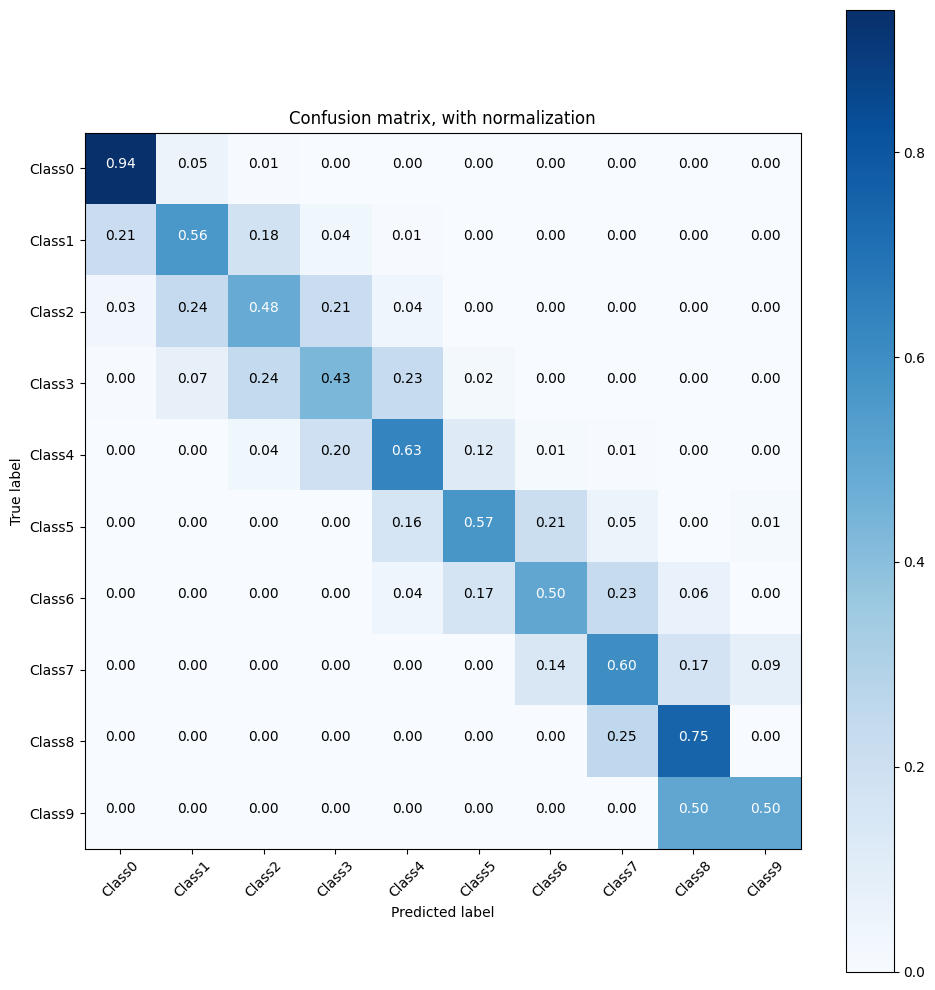

In [ ]:
cb_tuning = CatBoostClassifier(**cb_best_param, logging_level='Silent')
cb_tuning.fit(X_train, y_train)
cm1 = predict_cm(cb_tuning)

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm1[1], classes=labels, normalize='True',
                      title='Confusion matrix, with normalization')
plt.show()

In [ ]:
print(classification_report(cm1[0], y_test, target_names=target_names))

              precision    recall  f1-score   support

      Class0       0.97      0.94      0.95      3858
      Class1       0.52      0.56      0.54       559
      Class2       0.41      0.48      0.44       285
      Class3       0.44      0.43      0.43       258
      Class4       0.66      0.63      0.65       282
      Class5       0.49      0.57      0.53        81
      Class6       0.48      0.50      0.49        48
      Class7       0.54      0.60      0.57        35
      Class8       0.23      0.75      0.35         4
      Class9       0.20      0.50      0.29         2

    accuracy                           0.82      5412
   macro avg       0.49      0.60      0.52      5412
weighted avg       0.83      0.82      0.83      5412



**XGBoost**

Normalized confusion matrix
[[9.40197608e-01 5.14820593e-02 6.24024961e-03 1.56006240e-03
  5.20020801e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.08258528e-01 5.61938959e-01 1.74147217e-01 4.84739677e-02
  7.18132855e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.22950820e-02 2.19672131e-01 4.88524590e-01 1.86885246e-01
  3.93442623e-02 3.27868852e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.73134328e-03 9.32835821e-02 1.90298507e-01 4.14179104e-01
  2.83582090e-01 1.49253731e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.51879699e-03 4.13533835e-02 1.95488722e-01
  5.71428571e-01 1.61654135e-01 1.87969925e-02 3.75939850e-03
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.23456790e-02
  2.71604938e-01 4.56790123e-01 2.22222222e-01 3.70370370e-02
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+0

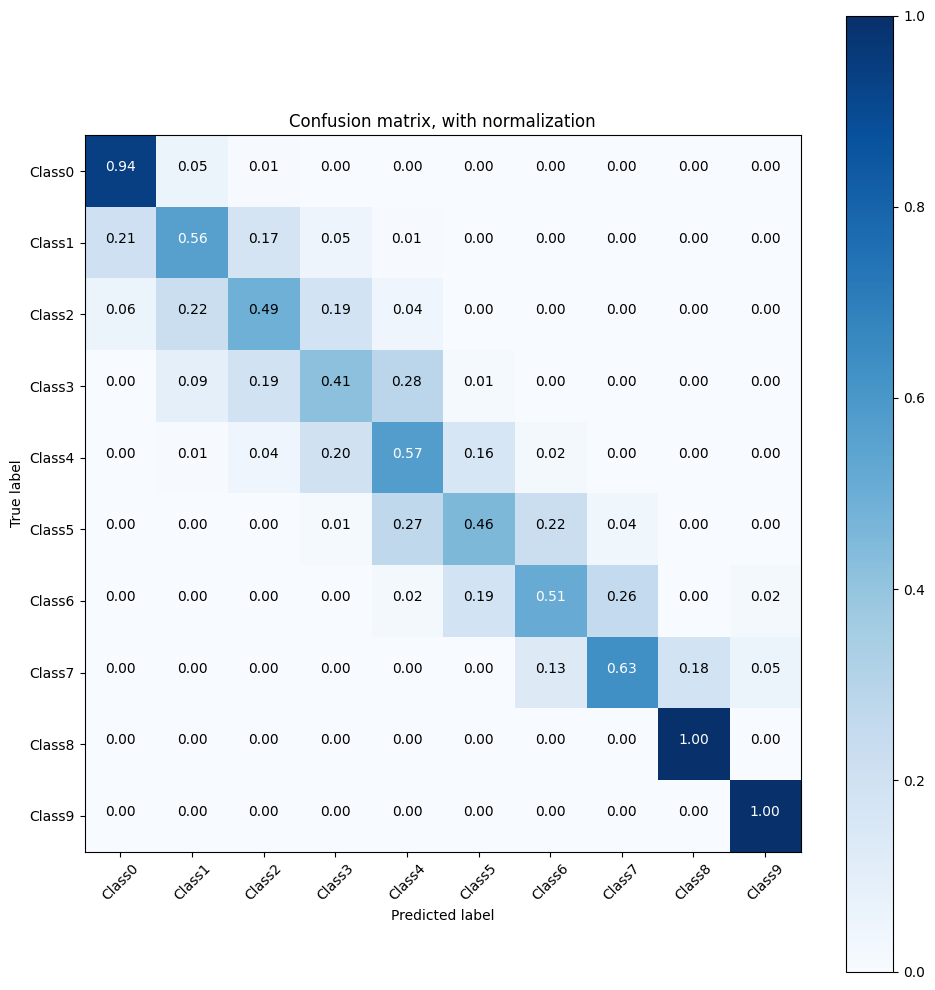

In [ ]:
xgb_tuning = XGBClassifier(**xgb_best_param) 
xgb_tuning.fit(X_train, y_train)
cm2 = predict_cm(xgb_tuning)

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm2[1], classes=labels, normalize='True',
                      title='Confusion matrix, with normalization')
plt.show()

In [ ]:
print(classification_report(cm2[0], y_test, target_names=target_names))

              precision    recall  f1-score   support

      Class0       0.96      0.94      0.95      3846
      Class1       0.52      0.56      0.54       557
      Class2       0.45      0.49      0.47       305
      Class3       0.44      0.41      0.43       268
      Class4       0.57      0.57      0.57       266
      Class5       0.40      0.46      0.43        81
      Class6       0.44      0.51      0.47        43
      Class7       0.62      0.63      0.62        38
      Class8       0.46      1.00      0.63         6
      Class9       0.40      1.00      0.57         2

    accuracy                           0.82      5412
   macro avg       0.52      0.66      0.57      5412
weighted avg       0.83      0.82      0.82      5412



**LightGBM**

Normalized confusion matrix
[[9.42202551e-01 5.05076803e-02 5.46732622e-03 1.30174434e-03
  5.20697735e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.18531469e-01 5.52447552e-01 1.76573427e-01 4.37062937e-02
  8.74125874e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.72108844e-02 2.41496599e-01 4.76190476e-01 2.10884354e-01
  4.42176871e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 8.13953488e-02 2.20930233e-01 4.45736434e-01
  2.36434109e-01 1.55038760e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.01351351e-02 4.39189189e-02 1.55405405e-01
  5.74324324e-01 1.75675676e-01 2.70270270e-02 1.35135135e-02
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.33333333e-02
  2.40000000e-01 4.26666667e-01 2.53333333e-01 5.33333333e-02
  1.33333333e-02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+0

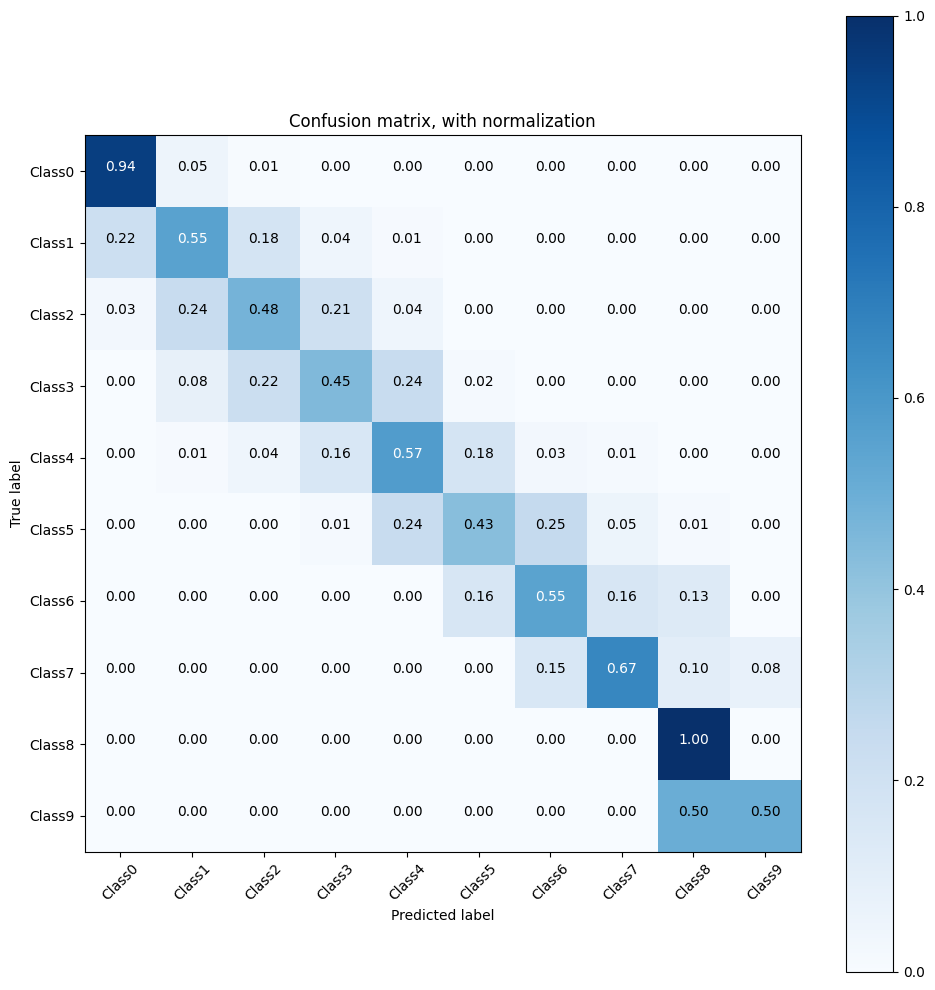

In [ ]:
lgb_tuning = LGBMClassifier(**lgb_best_param)
lgb_tuning.fit(X_train, y_train)
cm3 = predict_cm(lgb_tuning)

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm3[1], classes=labels, normalize='True',
                      title='Confusion matrix, with normalization')
plt.show()

In [ ]:
print(classification_report(cm3[0], y_test, target_names=target_names))

              precision    recall  f1-score   support

      Class0       0.96      0.94      0.95      3841
      Class1       0.52      0.55      0.54       572
      Class2       0.42      0.48      0.45       294
      Class3       0.45      0.45      0.45       258
      Class4       0.63      0.57      0.60       296
      Class5       0.34      0.43      0.38        75
      Class6       0.34      0.55      0.42        31
      Class7       0.67      0.67      0.67        39
      Class8       0.15      1.00      0.27         2
      Class9       0.40      0.50      0.44         4

    accuracy                           0.82      5412
   macro avg       0.49      0.61      0.52      5412
weighted avg       0.83      0.82      0.82      5412



# Feature Importance

In [ ]:
def drop_features_less_importances(models):
    data_drop_feat = data
    importances_model = models.feature_importances_
    importances = []
    features = []

    # Sort the feature importance in descending order
    sorted_indices = np.argsort(importances_model)[::-1]
    feat_labels = data.columns

    for f in range(X.shape[1]):
      u = feat_labels[sorted_indices[f]]
      d = "Steamspy_tags_Other"
      if u != d:
        if (u[0:5] == d[0:5]):
          importances.append(importances_model[sorted_indices[f]])
          features.append(feat_labels[sorted_indices[f]])
    
    importances_model = pd.DataFrame.from_dict(data = {'features': features, 'importances': importances})
    less_importances_features = importances_model[importances_model['importances'] <= 0]

    for i in less_importances_features["features"]:
      data_drop_feat = data_drop_feat.drop([i], axis = 1)
    
    X_drop_feat = data_drop_feat.drop(['Estimated_sales'], axis = 1)
    y_drop_feat = data_drop_feat['Estimated_sales']

    return [X_drop_feat, y_drop_feat, data_drop_feat]

In [ ]:
cb_drop_feat = CatBoostClassifier(**cb_best_param, logging_level='Silent')
xgb_drop_feat = XGBClassifier(**xgb_best_param) 
lgb_drop_feat = LGBMClassifier(**lgb_best_param)

In [ ]:
ml_tuning = [cb_tuning, xgb_tuning, lgb_tuning]

for x in ml_tuning:
  data_drop_features = drop_features_less_importances(x)
  X_train , X_test , y_train , y_test = train_test_split(data_drop_features[0] , data_drop_features[1] , test_size = 0.2 , random_state = 110)
  
  if x == cb_tuning:
    cb_drop_feat.fit(X_train, y_train)
  elif x ==  xgb_tuning: 
    xgb_drop_feat.fit(X_train, y_train)
  else:
    lgb_drop_feat.fit(X_train, y_train)

# Result

In [ ]:
ml_var = [cb, cb_tuning, cb_drop_feat, xgb, xgb_tuning, xgb_drop_feat, lgb, lgb_tuning, lgb_drop_feat]
ml_name = [
    'CatBoost', 'CatBoost Tuning', 'CatBoost Drop Feature', 
    'XGBoost', 'XGBoost Tuning', 'XGBoost Drop Feature', 
    'LightGBM', 'LightGBM Tuning', 'LightGBM Drop Feature'
]
ml_drop_feat = [cb_drop_feat, xgb_drop_feat, lgb_drop_feat]

**Train Score**

In [ ]:
# ทำการตรวจสอบความแม่นยำโดยใช้ Accuracy Score / F1 Score / AUC Score (Area Under <ROC> Curve)
auc_train_score = []
acc_train_score = []
F1_train_score = []

best_acc_train_score, best_f1_train_score, best_auc_train_score,= 0, 0, 0
best_acc_train_ML, best_f1_train_ML, best_auc_train_ML = '', '', ''

for x in ml_var:

  if x in ml_drop_feat:
      if x == cb_drop_feat:
        z = cb_tuning
      elif x ==  xgb_drop_feat: 
        z = xgb_tuning
      else:
        z = lgb_tuning

      data_drop_features = drop_features_less_importances(z)
      X_train , X_test , y_train , y_test = train_test_split(data_drop_features[0] , data_drop_features[1] , test_size = 0.2 , random_state = 110) 
  else:
      X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.2 , random_state = 110)

  y_pred = x.predict(X_train) 
  pred_prob = x.predict_proba(X_train)  

  # Accuracy Score 
  acc_train_score.append(accuracy_score(y_train, y_pred))
  if accuracy_score(y_train, y_pred) > best_acc_train_score:
    best_acc_train_score = accuracy_score(y_train, y_pred)
    best_acc_train_ML = ml_name[ml_var.index(x)]

  # F1 Score
  F1_train_score.append(f1_score(y_train, y_pred, average='weighted'))
  if f1_score(y_train, y_pred, average='weighted') > best_f1_train_score:
    best_f1_train_score = f1_score(y_train, y_pred, average='weighted')
    best_f1_train_ML = ml_name[ml_var.index(x)]

  # AUC Score
  auc_train_score_cal = roc_auc_score(y_train, pred_prob, multi_class='ovr', average='weighted')
  auc_train_score.append(auc_train_score_cal)
  if auc_train_score_cal > best_auc_train_score:
    best_auc_train_score = auc_train_score_cal
    best_auc_train_ML = ml_name[ml_var.index(x)]

train_score_df = pd.DataFrame(list(zip(ml_name, acc_train_score, F1_train_score, auc_train_score)), columns=['Model', 'Accuracy Train Score', 'F1 Train Score', 'AUC Train Score'])
train_score_df

,Model,Accuracy Train Score,F1 Train Score,AUC Train Score
0,CatBoost,0.866211,0.862428,0.978263
1,CatBoost Tuning,0.930518,0.928819,0.989125
2,CatBoost Drop Feature,0.931950,0.930225,0.989475
3,XGBoost,0.932505,0.930460,0.990119
4,XGBoost Tuning,0.981890,0.981645,0.998913
5,XGBoost Drop Feature,0.981659,0.981428,0.998861
6,LightGBM,0.915319,0.912827,0.987051
7,LightGBM Tuning,0.982676,0.982378,0.999069
8,LightGBM Drop Feature,0.981105,0.980768,0.998911


**Test Score**

In [ ]:
# ทำการตรวจสอบความแม่นยำโดยใช้ Accuracy Score / F1 Score / AUC Score (Area Under <ROC> Curve)
auc_test_score = []
acc_test_score = []
F1_test_score = []

best_acc_test_score, best_f1_test_score, best_auc_test_score,= 0, 0, 0
best_acc_test_ML, best_f1_test_ML, best_auc_test_ML = '', '', ''

for x in ml_var:

  if x in ml_drop_feat:
      if x == cb_drop_feat:
        z = cb_tuning
      elif x ==  xgb_drop_feat: 
        z = xgb_tuning
      else:
        z = lgb_tuning

      data_drop_features = drop_features_less_importances(z)
      X_train , X_test , y_train , y_test = train_test_split(data_drop_features[0] , data_drop_features[1] , test_size = 0.2 , random_state = 110) 
  else:
      X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.2 , random_state = 110)

  y_pred = x.predict(X_test) 
  pred_prob = x.predict_proba(X_test)  

  # Accuracy Score 
  acc_test_score.append(accuracy_score(y_test, y_pred))
  if accuracy_score(y_test, y_pred) > best_acc_test_score:
    best_acc_test_score = accuracy_score(y_test, y_pred)
    best_acc_test_ML = ml_name[ml_var.index(x)]

  # F1 Score
  F1_test_score.append(f1_score(y_test, y_pred, average='weighted'))
  if f1_score(y_test, y_pred, average='weighted') > best_f1_test_score:
    best_f1_test_score = f1_score(y_test, y_pred, average='weighted')
    best_f1_test_ML = ml_name[ml_var.index(x)]

  # AUC Score
  auc_test_score_cal = roc_auc_score(y_test, pred_prob, multi_class='ovr', average='weighted')
  auc_test_score.append(auc_test_score_cal)
  if auc_test_score_cal > best_auc_test_score:
    best_auc_test_score = auc_test_score_cal
    best_auc_test_ML = ml_name[ml_var.index(x)]

test_score_df = pd.DataFrame(list(zip(ml_name, acc_test_score, F1_test_score, auc_test_score)), columns=['Model', 'Accuracy Test Score', 'F1 Test Score', 'AUC Test Score'])
test_score_df

,Model,Accuracy Test Score,F1 Test Score,AUC Test Score
0,CatBoost,0.819660,0.814388,0.970010
1,CatBoost Tuning,0.823356,0.818563,0.970540
2,CatBoost Drop Feature,0.824649,0.820201,0.971266
3,XGBoost,0.819660,0.815042,0.968897
4,XGBoost Tuning,0.818921,0.815220,0.969054
5,XGBoost Drop Feature,0.819660,0.815917,0.968985
6,LightGBM,0.819660,0.814500,0.968823
7,LightGBM Tuning,0.820214,0.815599,0.968999
8,LightGBM Drop Feature,0.820030,0.815677,0.968681


In [ ]:
best_test_ml = pd.DataFrame({'Model': [best_acc_test_ML, best_f1_test_ML, best_acc_test_ML], 
                        'Score': [best_acc_test_score, best_f1_test_score, best_auc_test_score]},
                        index=['Best Accuracy', 'Best F1', 'Best AUC'])
best_test_ml

,Model,Score
Best Accuracy,CatBoost Drop Feature,0.824649
Best F1,CatBoost Drop Feature,0.820201
Best AUC,CatBoost Drop Feature,0.971266


Normalized confusion matrix
[[9.41268191e-01 5.06756757e-02 6.23700624e-03 1.55925156e-03
  2.59875260e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.14539007e-01 5.74468085e-01 1.70212766e-01 3.19148936e-02
  8.86524823e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.74914089e-02 2.43986254e-01 4.91408935e-01 2.09621993e-01
  2.40549828e-02 3.43642612e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.93700787e-03 5.11811024e-02 2.36220472e-01 4.40944882e-01
  2.51968504e-01 1.57480315e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.96864111e-03 3.13588850e-02 1.98606272e-01
  6.06271777e-01 1.42857143e-01 1.04529617e-02 3.48432056e-03
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.07792208e-01 4.80519481e-01 2.46753247e-01 6.49350649e-02
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+0

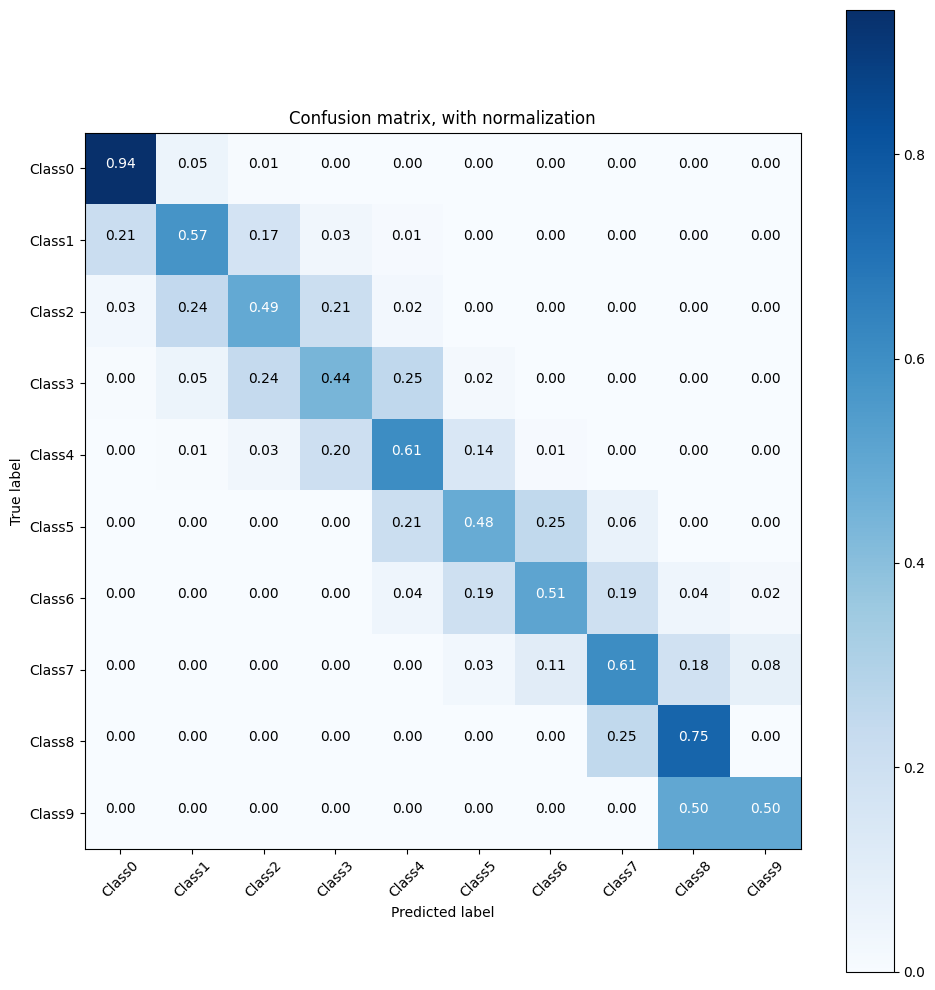

In [ ]:
data_drop_features = drop_features_less_importances(cb_tuning)
X_train , X_test , y_train , y_test = train_test_split(data_drop_features[0] , data_drop_features[1] , test_size = 0.2 , random_state = 110)
  
cm = predict_cm(cb_drop_feat)

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm[1], classes=labels, normalize='True',
                      title='Confusion matrix, with normalization')
plt.show()

In [ ]:
print(classification_report(cm[0], y_test, target_names=target_names))

              precision    recall  f1-score   support

      Class0       0.97      0.94      0.95      3848
      Class1       0.54      0.57      0.55       564
      Class2       0.43      0.49      0.46       291
      Class3       0.44      0.44      0.44       254
      Class4       0.65      0.61      0.63       287
      Class5       0.40      0.48      0.44        77
      Class6       0.48      0.51      0.49        47
      Class7       0.59      0.61      0.60        38
      Class8       0.23      0.75      0.35         4
      Class9       0.20      0.50      0.29         2

    accuracy                           0.82      5412
   macro avg       0.49      0.59      0.52      5412
weighted avg       0.83      0.82      0.83      5412



# Submission

In [ ]:
best_model = cb_drop_feat
pickle.dump(best_model, open('/content/drive/MyDrive/CP499_INDIVIDUAL_COMPUTER_PROJECT_II/Model/Submission/best_pc_game_with_rating_model.pkl', 'wb'))